<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import" data-toc-modified-id="Data-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Random-Forest-analysis" data-toc-modified-id="Random-Forest-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest analysis</a></span><ul class="toc-item"><li><span><a href="#get-the-X-and-y-arrays" data-toc-modified-id="get-the-X-and-y-arrays-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get the X and y arrays</a></span></li><li><span><a href="#Extract-feature-importance-from-the-RF-runs" data-toc-modified-id="Extract-feature-importance-from-the-RF-runs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract feature importance from the RF runs</a></span></li><li><span><a href="#Permutations-to-extract-p-values-for-each-metabolite" data-toc-modified-id="Permutations-to-extract-p-values-for-each-metabolite-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Permutations to extract p-values for each metabolite</a></span></li><li><span><a href="#Calculate-p-values" data-toc-modified-id="Calculate-p-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Calculate p-values</a></span></li><li><span><a href="#Write-final-results-to-file" data-toc-modified-id="Write-final-results-to-file-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Write final results to file</a></span></li></ul></li><li><span><a href="#Plots-(heatmap-and-sum-by-class)" data-toc-modified-id="Plots-(heatmap-and-sum-by-class)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots (heatmap and sum by class)</a></span><ul class="toc-item"><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Make-plots-for-each-candidate-summing-over-the-class" data-toc-modified-id="Make-plots-for-each-candidate-summing-over-the-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Make plots for each candidate summing over the class</a></span></li></ul></li><li><span><a href="#Comparison-with-Sacha's-candidates" data-toc-modified-id="Comparison-with-Sacha's-candidates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison with Sacha's candidates</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 

# custom functions
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs
from helper_functions import extract_feature_importances_from_random_forests_on_permuted_y
from helper_functions import get_significant_features
from helper_functions import plot_candidate_heatmap
from helper_functions import plot_candidate_sum_by_class
from helper_functions import get_sum_by_class_df


from helper_functions import single_random_forest_run

# Data import

In [2]:
df = pd.read_csv("phenotypes_vs_stem_terpenoids.tsv",sep="\t",index_col=0)

# Random Forest analysis 

## get the X and y arrays

In [3]:
# get whitefly classes
y = df["thrips"].tolist()
stratify_info = df['thrips'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

## Extract feature importance from the RF runs

In [4]:
# generates a list with three elements
# first element average of the feature importance 
# second element standard deviation of the feature importance
# third element accuracy score of the Random Forest model
feature_importances  = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

In [5]:
mean_varimportance = feature_importances[0].mean(axis=1)
# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importances[1]**2).mean(axis=1))
# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

In [6]:
# accuracy score of the model
print("This is the global accuracy score of the model:",feature_importances[2])

This is the global accuracy score of the model: 0.41


## Permutations to extract p-values for each metabolite 

In [7]:
# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    randomSeed=1234,
    njobs=2
)


feature_importance_perm_250 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=250,
    randomSeed=1234,
    njobs=2
)

feature_importance_perm_500 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=500,
    randomSeed=1234,
    njobs=2
)

## Calculate p-values

**How?** By comparing the average feature importance from the original dataset to the distribution of feature importance based on N permutations.   

In [8]:
all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)

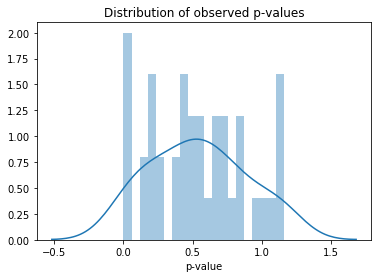

In [9]:
sns.distplot(all_pvalues.iloc[:,0].astype('float'),20)
plt.title('Distribution of observed p-values');

## Write final results to file

In [10]:
# Select significant variables
signif = all_pvalues.loc[all_pvalues.iloc[:,0]<0.05,:]
print(signif.shape[0],"significant candidates were identified")

5 significant candidates were identified


In [11]:
# write to table
signif.to_csv("../Table2/04.candidates_stem_volatiles_vs_thrips.tsv",sep="\t")

/anaconda3/envs/rf/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/rf/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


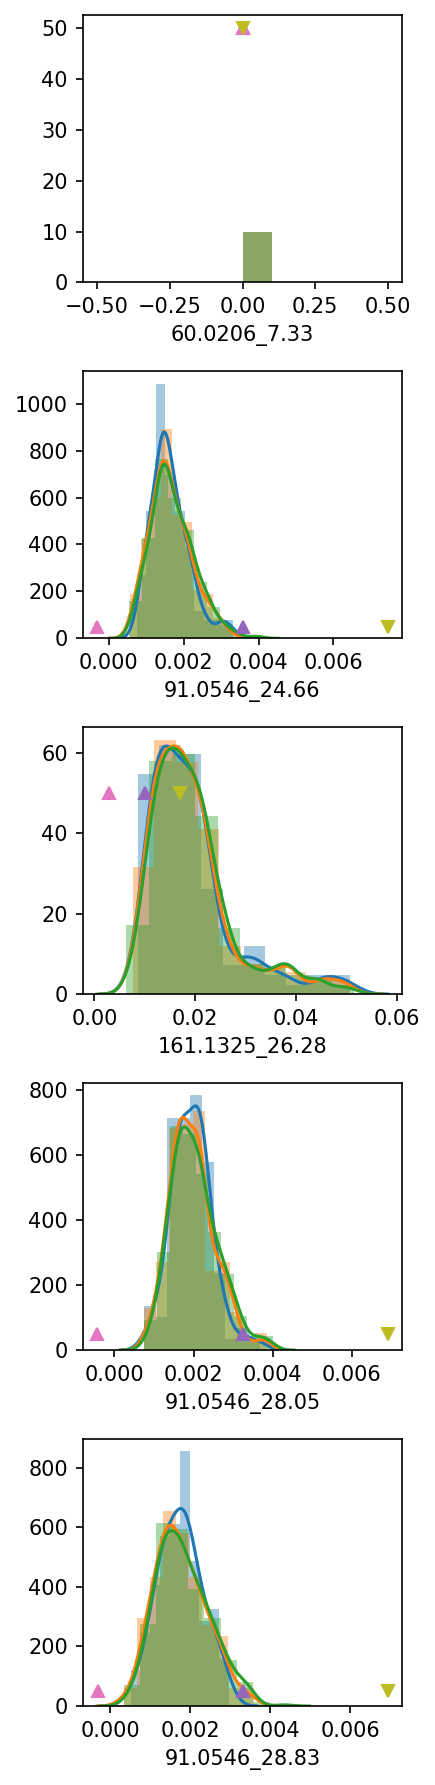

In [12]:
nrplots = len(signif.index.values)
fig = plt.figure(figsize=([3,12]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

#yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_250.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_500.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(yerr.loc[signif.index.values[i],1],0,yerr.loc[signif.index.values[i],1],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],0],0,yerr.loc[signif.index.values[i],0],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],2],0,yerr.loc[signif.index.values[i],2],50,'v')

    
plt.tight_layout()

# Plots (heatmap and sum by class)

## Heatmap
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

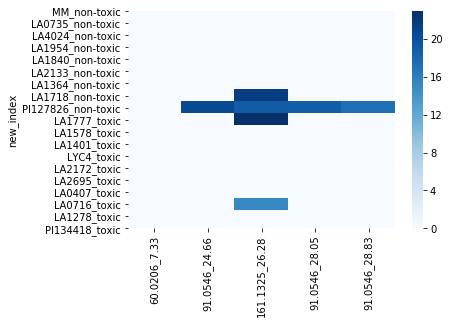

In [13]:
# drops the thrips columns
df_thrips = df.drop("wf",axis=1) 

# plot
plot_candidate_heatmap(
    df=df_thrips,
    class_col="thrips",
    significant=signif.index.values,
    log=True
)

## Make plots for each candidate summing over the class

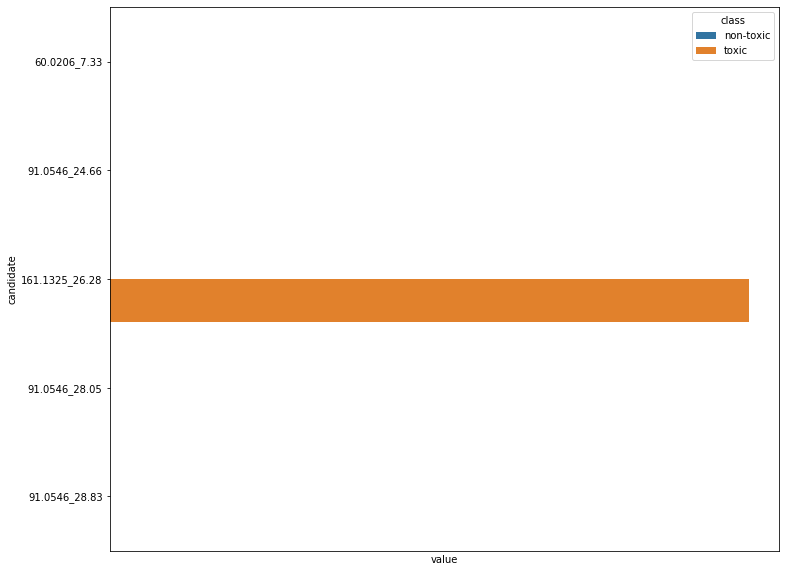

In [14]:
plot_candidate_sum_by_class(
    df = df_thrips,
    class_col = "thrips",
    significant=signif.index.values
)

# Comparison with Sacha's candidates

In [15]:
import pandas as pd
sacha = pd.read_csv("Sacha_RF_candidates_leaf_volatiles_vs_whiteflies.tsv",sep="\t",header=0)
sacha

,feature,p-value mwu_dataset,p-value p_pnorm,mda_mean
0,24.707_93.0725,0.007278,0.000892,0.024087
1,25.641_119.0875,0.037540,0.064500,0.001763
2,23.181_147.1173,0.018680,0.074000,0.005475
3,22.444_161.1317,0.035890,0.188000,0.007684
4,26.803_111.0836,0.037780,0.230000,0.001942
5,13.396_91.0579,0.031060,0.456000,0.000298


In [16]:
my_candidates = pd.read_csv("../Table2/03.candidates_leaf_volatiles_vs_thrips.tsv",sep="\t",header=0)
old_cols = my_candidates.columns.tolist()
new_cols = old_cols
new_cols[0]="feature"
my_candidates.columns = new_cols
my_candidates

,feature,p-value,average,sd,rsd
0,9.653_91.0565,0.000000,0.020557,0.004567,0.222145
1,11.844_91.0573,0.045977,0.084535,0.020272,0.239801
2,11.96_91.0560,0.000000,0.105807,0.018717,0.176899
3,12.373_91.0575,0.000000,0.117011,0.018720,0.159982
4,12.618_119.0885,0.022989,0.028552,0.006055,0.212070
5,12.761_91.0557,0.000000,0.122644,0.016747,0.136550
6,13.604_105.0725_blank,0.000000,0.021242,0.004506,0.212121
7,14.537_91.0571,0.011494,0.028365,0.009810,0.345849
8,15.562_91.0570,0.011494,0.000473,0.000356,0.752458
9,18.702_97.0318,0.045977,0.001402,0.000888,0.633269
